# LSTM Stock Predictor Using Closing Prices

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [73]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [74]:
import platform
print(platform.python_version())

3.7.9


In [75]:
# additional libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [76]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [77]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [78]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [79]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


### Add lagged prices
#### no need for lagged prices, they are done by routine.

In [80]:
test_df = df.copy()
test_df['Lag'] = test_df['Close'].shift()

In [81]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [82]:
test_df.head(5)

,fng_value,Close,Lag
2018-02-01,30,9114.719727,NaN
2018-02-02,15,8870.820313,9114.719727
2018-02-03,40,9251.269531,8870.820313
2018-02-04,24,8218.049805,9251.269531
2018-02-05,11,6937.080078,8218.049805


In [83]:
test_df.iloc[:, 0]

2018-02-01    30
2018-02-02    15
2018-02-03    40
2018-02-04    24
2018-02-05    11
              ..
2019-07-25    42
2019-07-26    24
2019-07-27    47
2019-07-28    16
2019-07-29    19
Name:  fng_value, Length: 543, dtype: int64

In [84]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

### set lagged as the target column

In [105]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X1, y = window_data(df, window_size, feature_column, target_column)

In [106]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X2, y = window_data(df, window_size, feature_column, target_column)

In [86]:
# delete
# # Predict Closing Prices using a 10 day window of previous closing prices
# # Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
# window_size = 10

# # Column index 0 is the 'fng_value' column
# # Column index 1 is the `Close` column
# feature_column = 1
# target_column = 1
# X, y = window_data(df, window_size, feature_column, target_column)

In [122]:
# X = np.stack((X1, X2), axis = 2)

In [118]:
# removed because stacking has to be done afterwards
# # Use 70% of the data for training and the remaineder for testing
# # YOUR CODE HERE!
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7)

In [136]:
# Use 70% of the data for training and the remaineder for testing
# YOUR CODE HERE!
# Do this for X1
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, train_size = .7)

In [137]:
# Use 70% of the data for training and the remaineder for testing
# YOUR CODE HERE!
# Do this for X2
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, train_size = .7)

In [127]:
# X[0].shape
# X.shape

(532, 10, 2)

In [142]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
# YOUR CODE HERE!
# scaler = MinMaxScaler().fit(np.array(y_vader_prob ).reshape (-1,1))
# y_vader_prob_norm = scaler.transform(np.array(y_vader_prob ).reshape (-1,1))
# scaler = MinMaxScaler().fit(y)
# y_scaled = scaler.transform(y)

# for X1
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X1, 2)

# Scale the features training and testing sets
X1_train = scaler.transform(X1_train)
X1_test = scaler.transform(X1_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)


In [140]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
# YOUR CODE HERE!
# scaler = MinMaxScaler().fit(np.array(y_vader_prob ).reshape (-1,1))
# y_vader_prob_norm = scaler.transform(np.array(y_vader_prob ).reshape (-1,1))
# scaler = MinMaxScaler().fit(y)
# y_scaled = scaler.transform(y)

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X2, 2)

# Scale the features training and testing sets
X2_train = scaler.transform(X2_train)
X2_test = scaler.transform(X2_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)


In [143]:
# X_train_copy = X_train.copy()
# X_test_copy = X_test.copy()

X_train = np.stack ((X1_train, X2_train),  axis = 2)
X_test = np.stack ((X1_test, X2_test), axis = 2)

In [ ]:
# Reshape the features for the model
# YOUR CODE HERE!
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
# print (f"X_train sample values:\n{X_train[:3]} \n")
# print (f"X_test sample values:\n{X_test[:3]}")

In [145]:
X_train.shape

(372, 10, 2)

In [144]:
# Reshape the features for the model
# YOUR CODE HERE!
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
# print (f"X_train sample values:\n{X_train[:3]} \n")
# print (f"X_test sample values:\n{X_test[:3]}")

ValueError: cannot reshape array of size 7440 into shape (372,10,1)

In [ ]:
print (f'X train oringinal  {X_train_copy.shape}')
print (f'X train {X_train.shape}')

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [146]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [147]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# YOUR CODE HERE!
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

# model = Sequential()

# # Initial model setup
# number_units = 30
# dropout_fraction = 0.2

# # Layer 1
# model.add(LSTM(
#     units=number_units,
#     return_sequences=True,
#     input_shape=(X_train.shape[1], 1))
#     )
# model.add(Dropout(dropout_fraction))

# # Layer 2
# model.add(LSTM(units=number_units, return_sequences=True))
# model.add(Dropout(dropout_fraction))

# # Layer 3
# model.add(LSTM(units=number_units))
# model.add(Dropout(dropout_fraction))

# # Output layer
# model.add(Dense(1))




In [148]:
# Compile the model
# YOUR CODE HERE!
model.compile(optimizer="adam", loss="mean_squared_error")

In [64]:
(X_train.shape[1], 1)

(10, 1)

In [149]:
# Summarize the model
# YOUR CODE HERE!
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 30)            3840      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [15]:
# Summarize the model
# YOUR CODE HERE!

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 10, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [150]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the dat5
# Experiement with the batch size, but a smaller batch size is recommended
# YOUR CODE HERE!
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10


ValueError: in user code:

    C:\Users\Hassan\Anaconda3\envs\pyvizenv\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\Hassan\Anaconda3\envs\pyvizenv\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Hassan\Anaconda3\envs\pyvizenv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Hassan\Anaconda3\envs\pyvizenv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Hassan\Anaconda3\envs\pyvizenv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Hassan\Anaconda3\envs\pyvizenv\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\Hassan\Anaconda3\envs\pyvizenv\lib\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    C:\Users\Hassan\Anaconda3\envs\pyvizenv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Hassan\Anaconda3\envs\pyvizenv\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:270 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer sequential_1: expected shape=(None, None, 1), found shape=(None, 10, 2)


In [16]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
# YOUR CODE HERE!


Epoch 1/10
371/371 [==============================] - 2s 5ms/step - loss: 0.0276
Epoch 2/10
371/371 [==============================] - 2s 5ms/step - loss: 0.0241
Epoch 3/10
371/371 [==============================] - 2s 6ms/step - loss: 0.0290
Epoch 4/10
371/371 [==============================] - 2s 6ms/step - loss: 0.0282
Epoch 5/10
371/371 [==============================] - 2s 5ms/step - loss: 0.0246
Epoch 6/10
371/371 [==============================] - 2s 6ms/step - loss: 0.0230
Epoch 7/10
371/371 [==============================] - 2s 6ms/step - loss: 0.0226
Epoch 8/10
371/371 [==============================] - 2s 6ms/step - loss: 0.0198
Epoch 9/10
371/371 [==============================] - 2s 5ms/step - loss: 0.0199
Epoch 10/10
371/371 [==============================] - 2s 5ms/step - loss: 0.0184


---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [54]:
# Evaluate the model
# YOUR CODE HERE!
model.evaluate(X_test, y_test, verbose=0)

0.04732043296098709

In [17]:
# Evaluate the model
# YOUR CODE HERE!

5/5 [==============================] - 0s 2ms/step - loss: 0.0487


0.048721764236688614

In [55]:
# Make some predictions
# YOUR CODE HERE!
predicted = model.predict(X_test)

In [56]:
# Recover the original prices instead of the scaled version
# predicted_prices = y_test_scaler.inverse_transform(predicted)
# real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [63]:
# debug
real_prices.ravel().shape
predicted_prices.ravel().shape
predicted.shape

(160, 1)

In [57]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,7503.200195,5972.820801
2019-02-21,6583.049805,6041.194824
2019-02-22,5289.750000,7729.470215
2019-02-23,5234.089844,7812.472656
2019-02-24,6632.870117,6640.729492


In [20]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,4248.814941
2019-02-21,3974.050049,4270.220703
2019-02-22,3937.040039,4296.877441
2019-02-23,3983.530029,4322.457520
2019-02-24,4149.089844,4345.416504



Bad key "text.kerning_factor" on line 4 in
C:\Users\Hassan\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


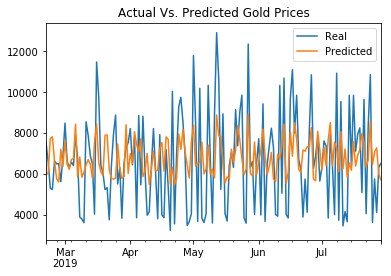

In [58]:
# Plot the real vs predicted values as a line chart
# YOUR CODE HERE!
stocks.plot(title="Actual Vs. Predicted Gold Prices")